# t-SNE

- t-SNE is t-distribution stochastic neighbor embedding


- developed in 2008, paper: Visualizing Data Using t-SNE


- good at preserving cluster/grouping structure


- t-SNE is a popular clustering method in Biomedical domain bc researchers want to know how many samples are in a same cluster

## motivation

- t-SNE focus on preserve **near neighbors**, rather than variance or Manifold distance

- the neighbors of data point $i$ in high dimension is same as its neighbors in low dimension

# Algorithm

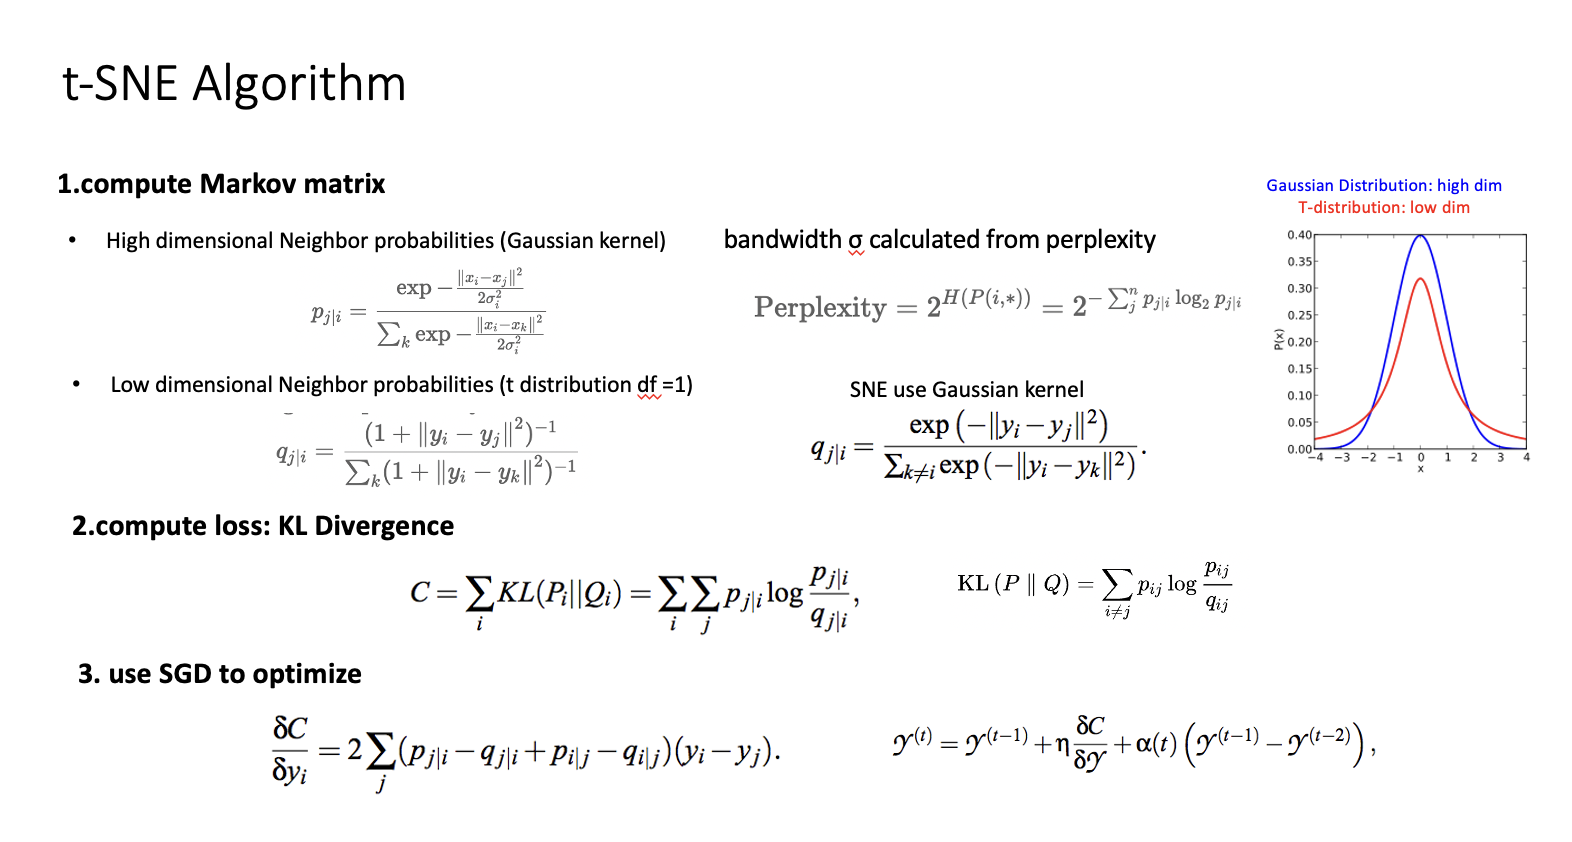

## step 1: compute two Markov-normalized affinity matrix

- Given a data matrix $X \in \mathbb{R}^{n \times p}$ which consists of $n$ high-dimensional data points $\mathbf{x}_i \in \mathbb{R}^{p}$

    t-SNE learn an embedding $Y \in \mathbb{R}^{n \times d}$ ($d$ is typically 2 or 3) which consists of $n$ low-dimensional data points $\mathbf{y} \in \mathbb{R}^{d}$

- high dimensional neighbors probability is Gaussian distribution

$$
 p_{j|i}=\frac{\exp{-\frac{\left \| x_i - x_j \right \|^2}{2\sigma_i^2}}}{\sum_k \exp{-\frac{\left \| x_i - x_k \right \|^2}{2\sigma_i^2}}}
$$

- low dimensional neighbors probability is t-distribution with df = 1

$$
q_{j|i}=\frac{(1+\left \| y_i - y_j \right \|^2)^{-1}}{\sum_k (1+\left \| y_i - y_k \right \|^2 )^{-1}}
$$

- conditional probability $p_{j|i}$ is probability that data point $\mathbf{x}_i$ will pick $\mathbf{x}_j$ as neighbor if neighbors were picked in proportion to their probability distribution under a Gaussian centered at $\mathbf{x}_i$, 

    which measures similarity of data point $\mathbf{x}_j$ to $\mathbf{x}_i$


- similarly, conditional probability $q_{j|i}$ measures similarity of data point $\mathbf{y}_j$ to $\mathbf{y}_i$

- **t-distribution**: we use a heavy-tailed Student t-distribution rather than Gaussian distribution for low dimensional data bc it allows dissimilar data points to be far apart

    so the clusters won't be overlapped but have clear contours

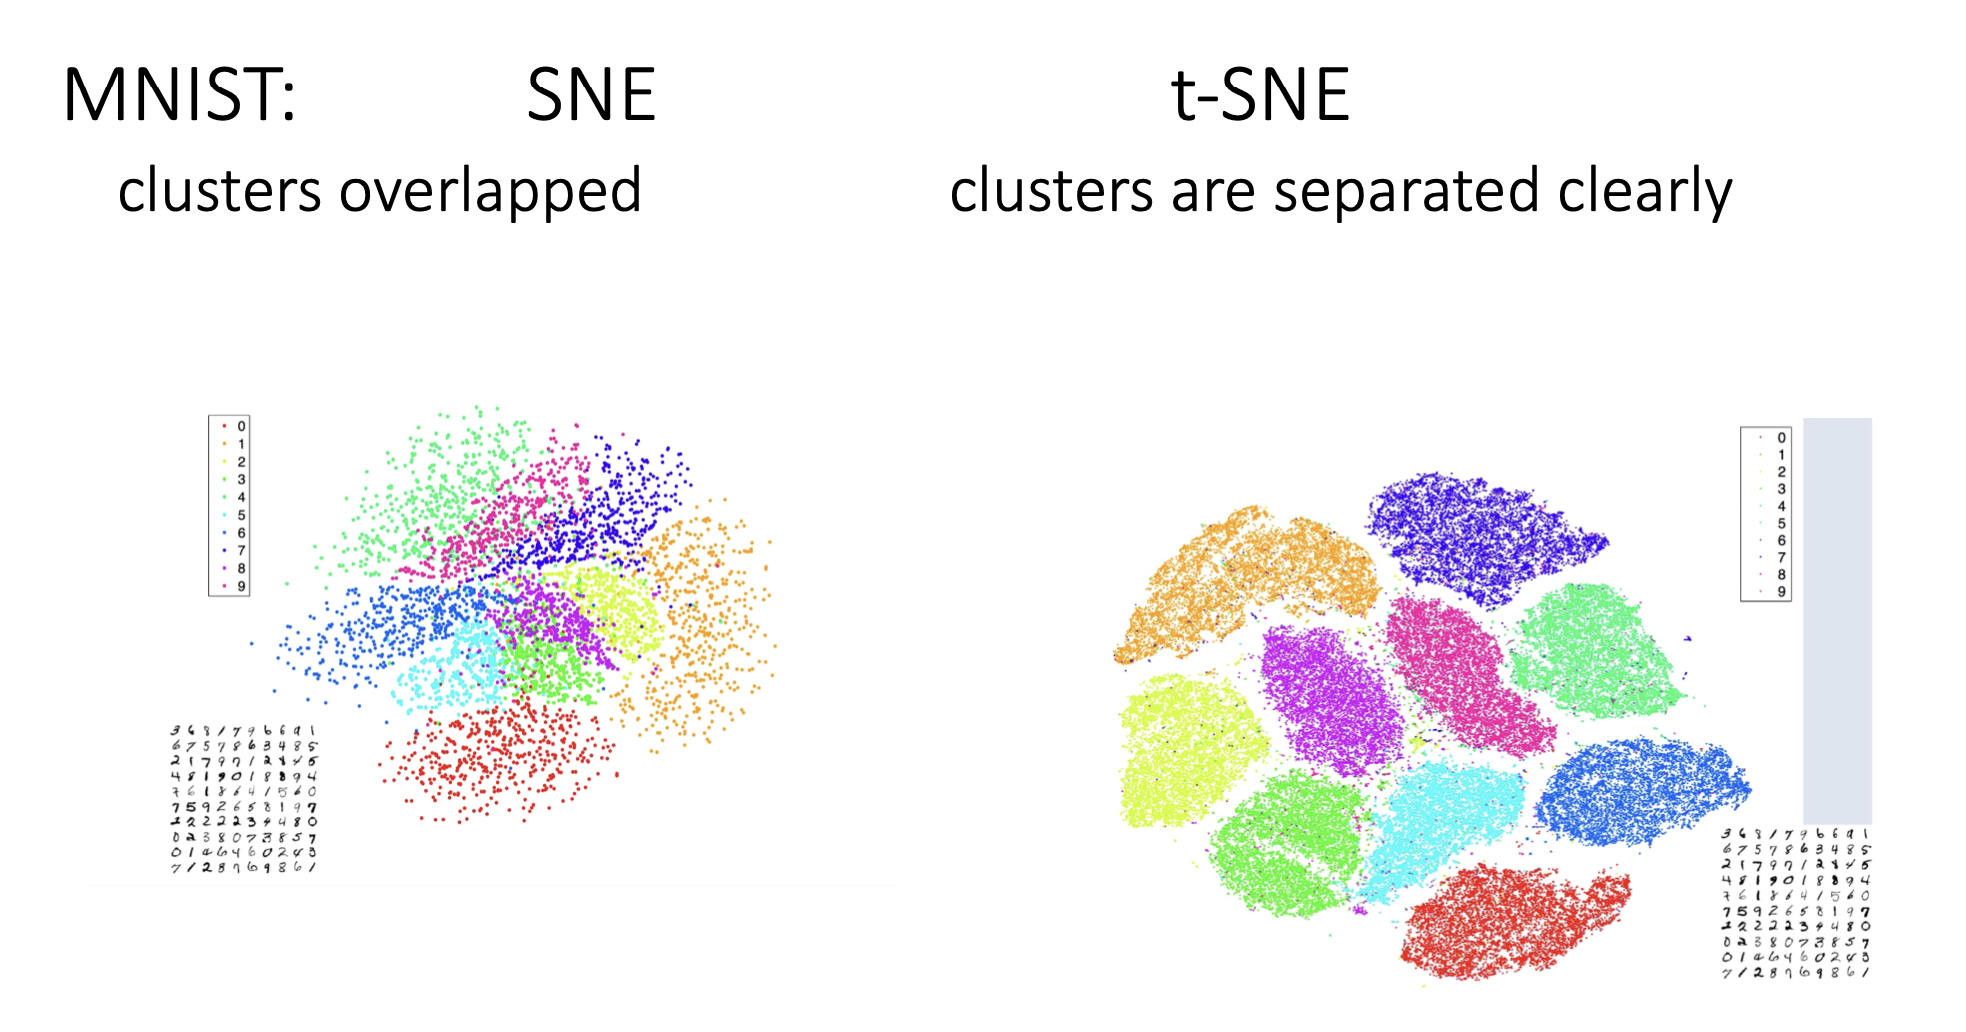

- Define

$$
P_{ij}=\frac{P_{i|j}+P_{j|i}}{2n}\\[1em]

P_{ii}=0, \sum_{j=1}^n p_{ij} = 1
$$


- Proof

    conditional probability $P_{i|j}=n P_{ij}$, $P_{j|i}=n P_{ji}$

    Markov matrix $P$ is symmetric:

$$
P_{ij}=P_{ji}=\frac{P_{i|j}}{n} = \frac{P_{j|i}}{n}
$$


- Affinity matrix of high dimensional use Gaussian kernel on distance matrix with **adaptive bandwidth** $\sigma_i$ for each data point

- Affinity matrix of low dimensional use t-distribution with degree of freedom 1 (SNE use Gaussian kernel)

- same as diffution map, row normalize affinity matrix to get Markov matrix, but no t step random walk

- adaptive bandwidth is calculate by setting a fixed perplexity, then do binary search to find bandwidth

- **perplexity**: effective number of neighbors of data point $i$, reflects our opinion of data density

$$\text{Perplexity}= 2^{H(P)}= 2^{-\sum_{j}^n p_{j|i}\log_2 p_{j|i}}$$ 

where $H(P(i,*))$ is Shannon Entropy

- by setting a fixed perplexity

  entropy of neighborhood of each point is even,

  each data point roughly has same number of **effective neighbors**,
    
  each cluster in t-SNE has even density,
    
  so **the number of points in a cluster is proportional to the size of cluster**,

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform

In [ ]:
def perplexity(P: np.ndarray) -> float:
    """Returns perplexity"""
    entropy = -np.sum(P * np.log2(P), axis=1)
    return 2 ** entropy

In [2]:
def P(dist: np.ndarray, sigmas: np.ndarray) -> np.ndarray:
    """Returns a Markov matrix (high dimensional neighbors probability)
        dist: distance matrix (n, n)
       sigmas: adaptive bandwidth matrix (n)
    """
    A = np.exp(-(dist/sigmas[:, None]) ** 2 / 2) # affinity matrix
    D = np.diag(A.sum(axis=1))
    M = np.linalg.inv(D) @ A 
    return M 

In [ ]:
def Q(dist: np.ndarray) -> np.ndarray:
    """Returns a Markov matrix (low dimensional neighbors probability)
        dist: distance matrix (n, n)
    """
    A = 1 / (1+dist) # affinity matrix
    D = np.diag(A.sum(axis=1))
    M = np.linalg.inv(D) @ A 
    return M 

## step 2: compute KL divergence

- objective: minimize KL divergence between probability distributions of high dim and low dim

$$
y = \arg \min_y C= \arg \min_y KL(P||Q)=\arg \min_y \sum_i \sum_j P(i,j) \log \frac{P(i,j)}{Q(i,j)}
$$

where $y_i$ is low dim embedding of point i

- divergence comes from info theory, like distance, but is **NOT symmetric**


- KL divergence: measures amount of extra info gained, when updating one distribution to another

    where $\log \frac{P(i,j)}{Q(i,j)}$ is ratio for ith point, $P(i,j)$ is weight for ith point

- when P and Q are very close, KL divergence will be very small, that's what we want

$$
\log \frac{P}{Q}=\log 1 = 0
$$

there are 2 conditions:

- if two points are close in original high dim data, 

    → $P(i,j)$ is large

    → to decrease penalty, $Q(i,j)$ must be very close to $P(i,j)$,
    
    → after iterations, points close in original high dim data becomes **closer** in low dim
    
    
- if two points are far away in original high dim data, 

    → $P(i,j)→0$

    → whatever $Q(i,j)$ is, penalty always →0, no control for $Q(i,j)$
    
    → after iterations, points far from each other in original high dim data might becomes **closer or farther** in low dim

- KL divergence e.g. on continuous functions:

    here $p(x)$ and $q(x)$ are both Gaussian distributions,
    
    the divergence is purple area under the curve

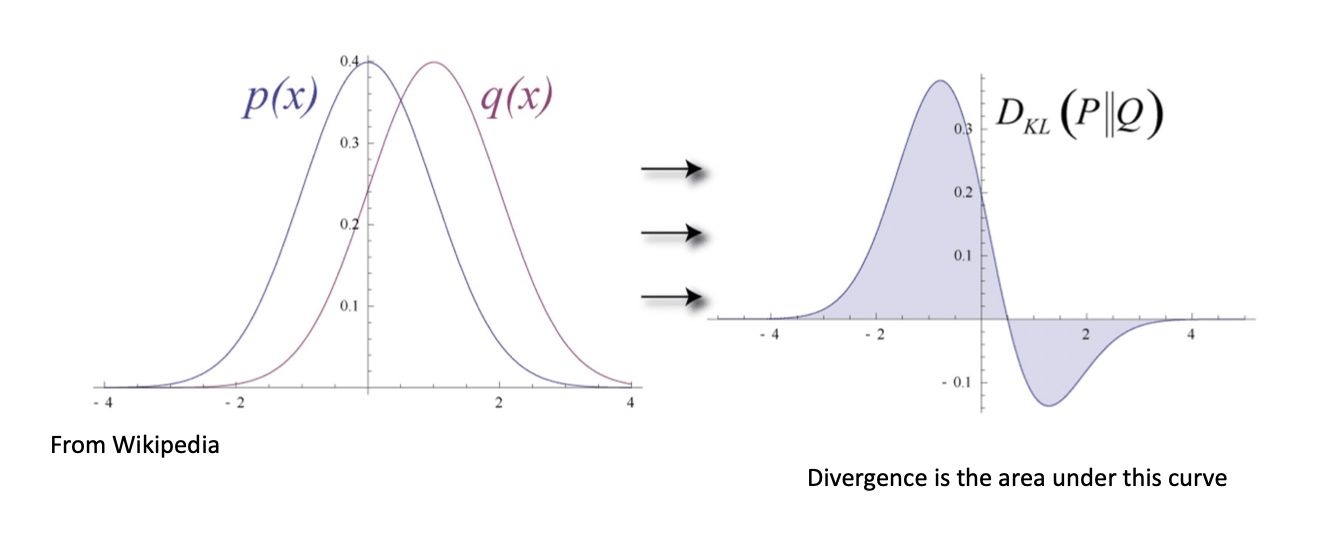

## step 3: use SGD to optimize

- objective: minimize KL divergence between probability distributions of high dim and low dim

$$
y = \arg \min_y C= \arg \min_y KL(P||Q)=\arg \min_y \sum_i \sum_j P(i,j) \log \frac{P(i,j)}{Q(i,j)}
$$

where $y_i$ is low dim embedding of point i

- take derivative of cost function $C$

$$
\frac{\delta C}{\delta y_i}=2\sum _j (p_{j|i}-q_{j|i}+p_{i|j}-q_{i|j})(y_i-y_j)
$$

- by stochastic gradient descent, 

    we start with a random embedding in **2-3D**,

    we greedily move each low dim points in small steps $\eta$ into a position that **increase the match** between high dim probabilities and low dim probabilities,


$$
y ^{(t)}=y ^{(t-1)} + \eta \frac{\delta C}{\delta y}+ \alpha(t)(y ^{(t-1)}-y ^{(t-2)} )
$$

where $\eta$ is learning rate

## t-SNE vs. diffusion maps, PHATE

- t-SNE use:

    - Euclidean distance matrix
    
    - Gaussian affinity matrix

    - Markov normalized matrix
    
    - match near neighbors using KL divergence
    

- t-SNE don't use

    - random walk
    
    - eigendecomposition of Markov matrix
    
    - MDS or distance preservation
    
    - a variant of kernel PCA